# Biosensor grating

Bragg gratings are structures which involve a periodic variation in the refractive index or geometry of waveguide, so that certain frequencies of light are reflected off the grating while others are transmitted.

Since gratings can be designed to be extremely sentitive, one possible application they have is to detect the presence of foreign molecules. If particles such as biomolecules are deposited on the device, it will no longer have the same reflective properties in the band of frequencies for which it was designed. Therefore, carefully-designed Bragg gratings can be used as biosensors.

In this example, an optical biosensor grating is modeled to detect the presence of biomolecules. The grating is designed to be reflective over a narrow band around its resonant frequency which is modified by the presence of a biomolecule.

Reference:  Brian Cunningham, Bo Lin, Jean Qiu, Peter Li, Jane Pepper, Brenda Hugh, "A plastic colorimetric resonant optical biosensor for multiparallel detection of label-free biochemical interactions," Sensors and Actuators B 85 (2002), DOI: [10.1016/S0925-4005(02)00111-9](https://doi.org/10.1016/S0925-4005(02)00111-9)

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# Tidy3D imports
import tidy3d as td


## Structure Setup

Create the grating geometry.

In [2]:
# materials
Si3N4 = td.Medium(permittivity=2.05**2)
epoxy = td.Medium(permittivity=1.5**2)
background = td.Medium(permittivity=1.333**2)

# set basic geometric parameters (units in microns)
nm = 1e-3
period = 550 * nm
grating_fill_factor = 0.5
grating_height = 200 * nm
film_height = 120 * nm
epoxy_height = 380 * nm
monitor_distance = 1.0
monitor_gap = 0.1

# the epoxy layer top surface is at z=0
sim_center = (0, 0, 0.5 * (grating_height + film_height - epoxy_height))
sim_size = (
    period,
    0,
    epoxy_height + grating_height + film_height + 2 * (monitor_distance + monitor_gap),
)

# wavelength / frequency setup
wavelength_min = 770 * nm
wavelength_max = 900 * nm
freq_min = td.C_0 / wavelength_max
freq_max = td.C_0 / wavelength_min
freq0 = (freq_min + freq_max) / 2.0
fwidth = freq_max - freq_min
run_time = 10e-12

# epoxy layer
epoxy_layer = td.Structure(
    geometry=td.Box(
        center=[0.0, 0.0, -0.5 * epoxy_height],
        size=[td.inf, td.inf, epoxy_height],
    ),
    medium=epoxy,
    name="epoxy_layer",
)

# bottom Si3N4 film layer
bottom_film = td.Structure(
    geometry=td.Box(
        center=[0.0, 0.0, 0.5 * film_height],
        size=[td.inf, td.inf, film_height],
    ),
    medium=Si3N4,
    name="bottom_film",
)

# epoxy grating teeth (partially covers the film layer)
grating_teeth = td.Structure(
    geometry=td.Box(
        center=[0.0, 0.0, 0.5 * grating_height],
        size=[period * grating_fill_factor, td.inf, grating_height],
    ),
    medium=epoxy,
    name="grating_teeth",
)

# top Si3N4 film layer
top_film = td.Structure(
    geometry=td.Box(
        center=[0.0, 0.0, grating_height + 0.5 * film_height],
        size=[period * grating_fill_factor, td.inf, film_height],
    ),
    medium=Si3N4,
    name="top_film",
)

# the order her matters, because the teeth must override the bottom film layer
geometry = [epoxy_layer, bottom_film, grating_teeth, top_film]

# boundary conditions: the simulation is periodic in the x-y plane, and simulates
# an infinite domain along z
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary.pml(),
)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=30)


## Source Setup

Create the plane wave source which excites the structure from underneath.

In [3]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
source = td.PlaneWave(
    center=[0, 0, -(epoxy_height + monitor_distance - monitor_gap)],
    size=[td.inf, td.inf, 0.0],
    source_time=source_time,
    pol_angle=0,
    direction="+",
)


## Monitor Setup

Create field and flux monitors to measure reflecting and transmitted flux.

In [4]:
# create field monitor
monitor_xz = td.FieldMonitor(
    center=sim_center,
    size=[td.inf, 0, td.inf],
    freqs=[freq0],
    name="fields_xz",
)

# create flux monitors
freqs = np.linspace(freq_min, freq_max, 1000)
monitor_flux_refl = td.FluxMonitor(
    center=[0, 0, -(epoxy_height + monitor_distance)],
    size=[td.inf, td.inf, 0.0],
    freqs=freqs,
    name="flux_refl",
)
monitor_flux_tran = td.FluxMonitor(
    center=[0, 0, grating_height + film_height + monitor_distance],
    size=[td.inf, td.inf, 0.0],
    freqs=freqs,
    name="flux_tran",
)

monitors = [monitor_xz, monitor_flux_refl, monitor_flux_tran]


## Create Simulation

The final simulation object is created and visualized.

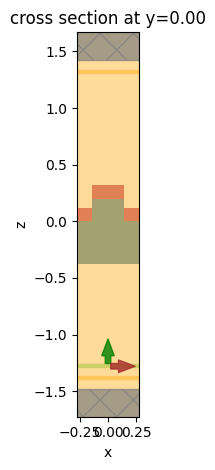

In [5]:
# create the simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    medium=background,
    shutoff=1e-6,
)

# plot the simulation domain
sim.plot(y=0)
plt.show()


## Run Simulation

In [6]:
# run simulation
import tidy3d.web as web

sim_data = web.run(sim, task_name="biosensor", path="data/biosensor.hdf5", verbose=True)


[13:46:55] Created task 'biosensor' with task_id 'fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1'.       ]8;id=768038;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=550258;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=349594;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=621628;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=713382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=497010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1\taskId]8;;\]8;id=713382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1\=]8;;\]8;id=217504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1\fdve]8;;\]8;id=713382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1\-b80c32cd-ed9b-494d-9400-e58a6c8c41c]8;;\              
           ]8;id=713382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b80c32cd-ed9b-494d-9400-e58a6c8c41c6v1\6v1']8;;\.                                                                                                   

Output()

[13:46:57] status = queued                                                                            ]8;id=523857;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=810357;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#321\321]8;;\

Output()

[13:47:00] status = preprocess                                                                        ]8;id=98484;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=741160;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#315\315]8;;\

[13:47:07] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=471249;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=465190;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=759401;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=412124;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=223095;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=927643;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#352\352]8;;\

Output()

[13:47:28] early shutoff detected, exiting.                                                           ]8;id=676563;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=606332;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=844107;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=25308;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#383\383]8;;\

Output()

[13:47:34] status = success                                                                           ]8;id=111492;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=945687;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#390\390]8;;\

Output()

[13:47:35] loading SimulationData from data/biosensor.hdf5                                            ]8;id=143739;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=590149;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

## Plot Fields

The frequency-domain fields recorded are plotted at the center frequency in an `xz` plane. The resonance can be clearly seen in the power flow pattern shown by the Poynting vector plots.

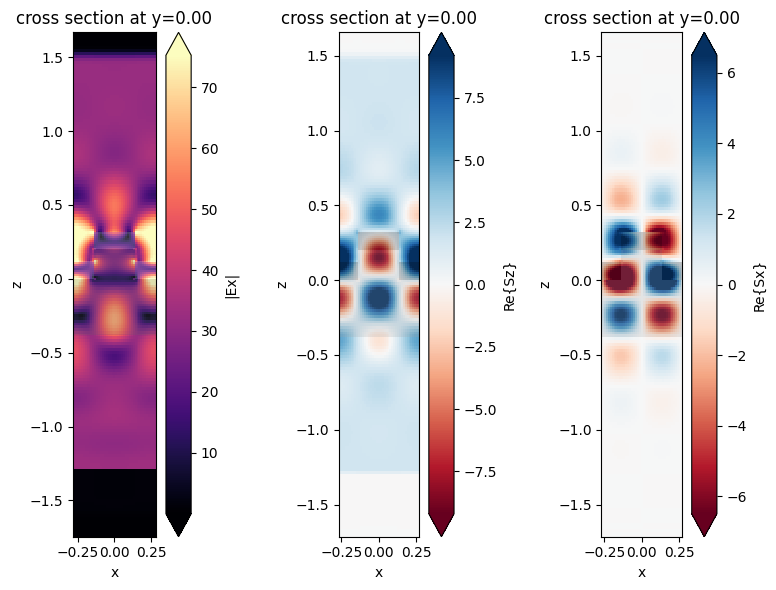

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(8, 6), tight_layout=True)

sim_data.plot_field("fields_xz", field_name="Ex", val="abs", f=freq0, ax=ax[0])
sim_data.plot_field("fields_xz", field_name="Sz", val="real", f=freq0, ax=ax[1])
sim_data.plot_field("fields_xz", field_name="Sx", val="real", f=freq0, ax=ax[2])
plt.show()


## Plot Transmission and Reflection

To see the effectiveness of the grating, we can compute and plot the reflection and transmission via the flux measured by the flux monitor. As the plot shows, the structure is highly reflective in a narrow frequency range around the design frequency, allowing one to detect small variations in the frequency response due to the presence of biological materials. The vertical dashed line shows the wavelength used in the previous plots.

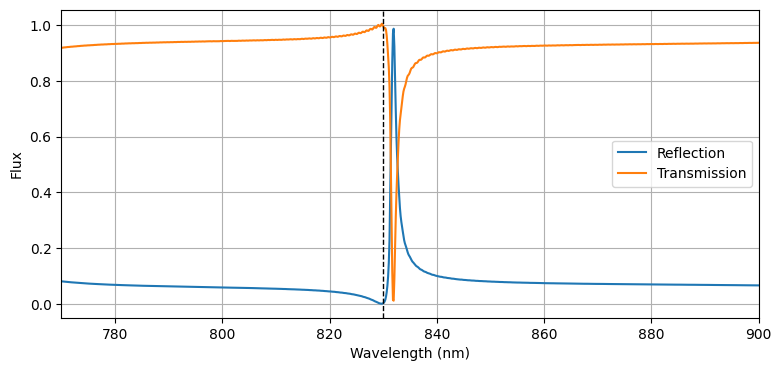

In [8]:
transmission = sim_data["flux_tran"].flux
reflection = -sim_data["flux_refl"].flux

fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(td.C_0 / freqs * 1e3, reflection, label="Reflection")
ax.plot(td.C_0 / freqs * 1e3, transmission, label="Transmission")

# wavelength for the field plots
ax.axvline(td.C_0 / freq0 * 1e3, ls="--", color="k", lw=1)

ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Flux",
    xlim=(wavelength_min * 1e3, wavelength_max * 1e3),
)
ax.legend()
ax.grid()
plt.show()
